In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install hdf5storage

     |████████████████████████████████| 53 kB 1.5 MB/s 


In [3]:
pip install mat73

In [4]:
import urllib.request
import os
import re
from tqdm import tqdm
import zipfile
import hdf5storage
import numpy as np

import scipy 
import sklearn
#from sklearn.feature_extraction import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from mat73 import loadmat

from skimage.transform import resize
from PIL import Image
import cv2


import pandas as pd
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

In [5]:
import shutil
shutil.rmtree('/content/drive/MyDrive/data')

FileNotFoundError: ignored

In [6]:
# 탄성변형
def elastic_transform(image, alpha, sigma, alpha_affine, random_state=None):
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    shape_size = shape[:2]
    
    # Random affine
    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 3
    pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size], center_square - square_size])
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dz = np.zeros_like(dx)

    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

    return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)

# 데이터
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def download_url(url, target_folder, filename):
    # check if data exists
    print("Check if data exists on disk")
    if not os.path.isdir(target_folder):
      print("Creating target folder")
      os.mkdir(target_folder)
    files = os.listdir(target_folder)
    if not files:
        print("Cannot find files on disk")
        print("Downloading files")
        with DownloadProgressBar(unit='B', unit_scale=True,
                                 miniters=1, desc=url.split('/')[-1]) as t:
            urllib.request.urlretrieve(url, filename=target_folder + filename, reporthook=t.update_to)
    print("Download completed!")

def unzip_all_files(target_folder):
    print("Unzip files")
    items = os.listdir(target_folder)
    while(any(item.endswith('.zip') for item in items)):
        for item in filter(lambda item: item.endswith('.zip'), items):
            with zipfile.ZipFile(target_folder + item, "r") as zip_ref:
                zip_ref.extractall(target_folder)
        for item in items:
            if item.endswith(".zip"):
                os.remove(target_folder + item)
        items = os.listdir(target_folder)
    print("Unzip completed!")

def _arrange_brain_tumor_data(root):
    # Remove and split files
    items = [item for item in filter(lambda item: re.search("^[0-9]+\.mat$", item), os.listdir(root))]
    try:
        os.mkdir(root + 'meningioma/')
    except:
        print("Meningioma directory already exists")
    try:
        os.mkdir(root + 'glioma/')
    except:
      print("Glioma directory already exists")
    try:
        os.mkdir(root + 'pituitary/')
    except:
        print("Pituitary directory already exists")

    # image directory 생성
    try:
        os.mkdir(root + 'meningioma/image/')
    except:
        print("Meningioma_image directory already exists")
    try:
        os.mkdir(root + 'glioma/image/')
    except:
      print("Glioma_image directory already exists")
    try:
        os.mkdir(root + 'pituitary/image/')
    except:
        print("Pituitary_image directory already exists")    

    # mask directory 생성
    try:
        os.mkdir(root + 'meningioma/mask/')
    except:
        print("Meningioma_mask directory already exists")
    try:
        os.mkdir(root + 'glioma/mask/')
    except:
      print("Glioma_mask directory already exists")
    try:
        os.mkdir(root + 'pituitary/mask/')
    except:
        print("Pituitary_mask directory already exists")    
    

    m_count = 1
    g_count = 1
    p_count = 1

    for item in items:
        matfile = loadmat(root + item)
        
        image = matfile['cjdata']['image']
        mask = matfile['cjdata']['tumorMask']

        image = resize(image, (256, 256))
        mask = resize(mask, (256, 256))

        image_formatted = (image * 255 / np.max(image)).astype('uint8')
        image_jpg = Image.fromarray(image_formatted)

        mask_formatted = (mask * 255 / np.max(mask)).astype('uint8')
        mask_jpg = Image.fromarray(mask_formatted)


        # meningioma
        if int(matfile['cjdata']['label']) == 1:      
            image_jpg.save(os.path.join(root + 'meningioma/image/' ,f'{m_count}.jpg'))
            mask_jpg.save(os.path.join(root + 'meningioma/mask/' ,f'{m_count}.jpg'))
                    
            # 탄성변형
            path1 = os.path.join(root + 'meningioma/image/' ,f'{m_count}.jpg')
            path2 = os.path.join(root + 'meningioma/mask/' ,f'{m_count}.jpg')
                    
            im = cv2.imread(path1, -1)
            im_mask = cv2.imread(path2, -1)
            
            im_merge = np.concatenate((im[...,None], im_mask[...,None]), axis=2)
            im_merge_t = elastic_transform(im_merge, im_merge.shape[1] * 2, im_merge.shape[1] * 0.08, im_merge.shape[1] * 0.08)
            im_t = im_merge_t[...,0]
            im_mask_t = im_merge_t[...,1]

            im_t_formatted = np.array(im_t)
            im_t = Image.fromarray(im_t_formatted)
            im_mask_t_formatted = np.array(im_mask_t)
            im_mask_t = Image.fromarray(im_mask_t_formatted)
                    
            im_t.save(os.path.join(root + 'meningioma/image/' ,f'{m_count}_t.jpg'))
            im_mask_t.save(os.path.join(root + 'meningioma/mask/' ,f'{m_count}_t.jpg'))
            m_count += 1
                            
        # glioma
        elif int(matfile['cjdata']['label']) == 2:
           path1 = os.path.join(root + 'glioma/image/' ,f'{g_count}.jpg')
           path2 = os.path.join(root + 'glioma/mask/' ,f'{g_count}.jpg')         
           image_jpg.save(path1)
           mask_jpg.save(path2)
           g_count += 1
            
        # pituitary
        elif int(matfile['cjdata']['label']) == 3:
            image_jpg.save(os.path.join(root + 'pituitary/image/' ,f'{p_count}.jpg'))
            mask_jpg.save(os.path.join(root + 'pituitary/mask/' ,f'{p_count}.jpg'))
                
            # 탄성변형
            path1 = os.path.join(root + 'pituitary/image' ,f'{p_count}.jpg')
            path2 = os.path.join(root + 'pituitary/mask' ,f'{p_count}.jpg') 
            im = cv2.imread(path1, -1)
            im_mask = cv2.imread(path2, -1)
            im_merge = np.concatenate((im[...,None], im_mask[...,None]), axis=2)
            im_merge_t = elastic_transform(im_merge, im_merge.shape[1] * 2, im_merge.shape[1] * 0.08, im_merge.shape[1] * 0.08)
            im_t = im_merge_t[...,0]
            im_mask_t = im_merge_t[...,1]

            im_t_formatted = np.array(im_t)
            im_t = Image.fromarray(im_t_formatted)
            im_mask_t_formatted = np.array(im_mask_t)
            im_mask_t = Image.fromarray(im_mask_t_formatted)
                
            im_t.save(os.path.join(root + 'pituitary/image/' ,f'{p_count}_t.jpg'))
            im_mask_t.save(os.path.join(root + 'pituitary/mask/' ,f'{p_count}_t.jpg'))

            p_count += 1

        # 기존 matfile 삭제
        os.remove(root + item)


def get_data_if_needed(data_path='/content/drive/MyDrive/data/', url="https://ndownloader.figshare.com/articles/1512427/versions/5"):
    if os.path.isdir(data_path): # 이미 데이터를 받았을 경우
        print("Data directory already exists. ")
        _arrange_brain_tumor_data(data_path)
        return
    filename = "all_data.zip"
    download_url(url, data_path, filename)
    unzip_all_files(data_path)
    _arrange_brain_tumor_data(data_path)




In [7]:
get_data_if_needed("/content/drive/MyDrive/data/")

Check if data exists on disk
Creating target folder
Cannot find files on disk


5: 880MB [00:27, 32.5MB/s]                           


Download completed!
Unzip files
Unzip completed!


In [ ]:
matfile = loadmat("/content/drive/MyDrive/59.mat")
print(matfile['cjdata'].keys())

dict_keys(['PID', 'image', 'label', 'tumorBorder', 'tumorMask'])


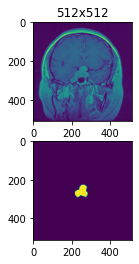

In [ ]:
image = matfile['cjdata']['image']
mask = matfile['cjdata']['tumorMask']

plt.subplot(2, 2, 1)
plt.title('512x512')
plt.imshow(image)

plt.subplot(2, 2, 3)
plt.imshow(mask)

In [ ]:
import shutil
shutil.rmtree('/content/drive/MyDrive/testdata')

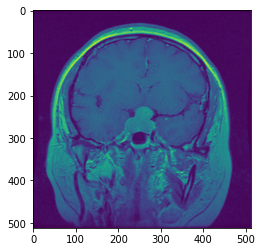

In [ ]:
   
label= int(matfile['cjdata']['label'])

if (label == 3):
   
    dir = "/content/drive/MyDrive/testdata/"
    image_file_name = 'testdata.jpg'
    mask_file_name = f'testdata_mask.jpg'
    #print(mask_file_name)

    image = resize(image, (512, 512))
    mask = resize(mask, (512, 512))
    
    # image 실수 -> 정수 변환 (jpg로 저장하기 위해서)
    image_formatted = (image * 255 / np.max(image)).astype('uint8')
    image_jpg = Image.fromarray(image_formatted)
    image_jpg.save(os.path.join(dir,image_file_name))
    plt.imshow(image_jpg)
    
    mask_formatted = (mask * 255 / np.max(mask)).astype('uint8')
    mask_jpg = Image.fromarray(mask_formatted)
    mask_jpg.save(os.path.join(dir,mask_file_name))
    #plt.imshow(mask_jpg)

In [ ]:
def elastic_transform(image, alpha, sigma, alpha_affine, random_state=None):
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    shape_size = shape[:2]
    
    # Random affine
    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 3
    pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size], center_square - square_size])
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dz = np.zeros_like(dx)

    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

    return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)

In [ ]:
# Load images
root = "/content/drive/MyDrive/"
im = cv2.imread("/content/drive/MyDrive/testdata/testdata.jpg", -1)
im_mask = cv2.imread("/content/drive/MyDrive/testdata/testdata_mask.jpg", -1)

# Merge images into separete channels (shape will be (cols, rols, 2))
im_merge = np.concatenate((im[...,None], im_mask[...,None]), axis=2)

In [ ]:
print(im_merge.shape[1], im.shape[1])

512 512


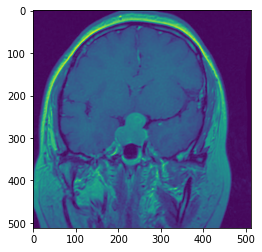

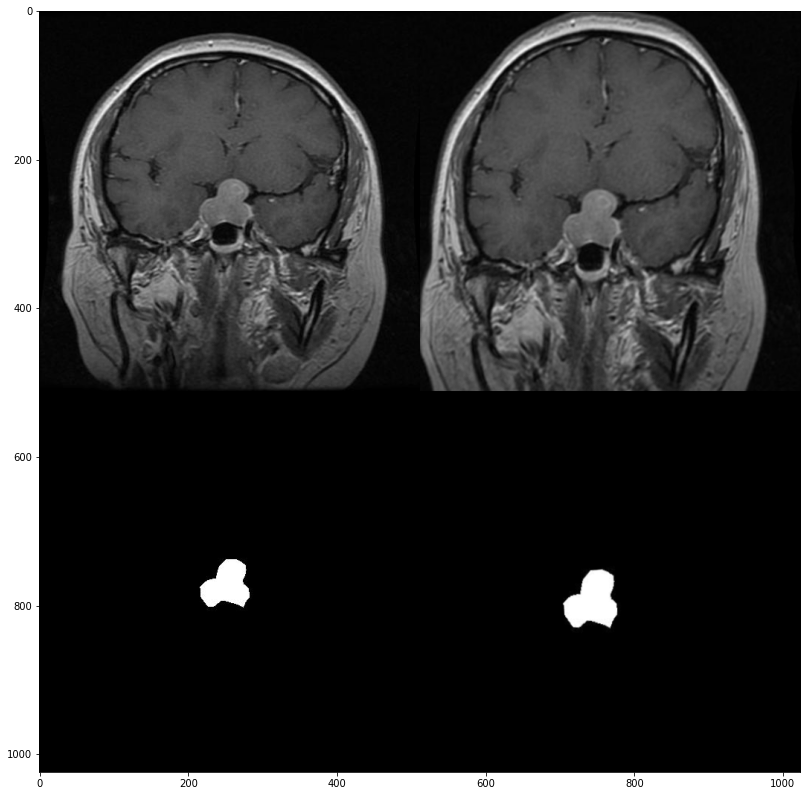

In [ ]:


%matplotlib inline

# Apply transformation on image
im_merge_t = elastic_transform(im_merge, im_merge.shape[1] * 2, im_merge.shape[1] * 0.08, im_merge.shape[1] * 0.08)
# Split image and mask
im_t = im_merge_t[...,0]
im_mask_t = im_merge_t[...,1]
plt.imshow(im_t)
plt.figure(figsize = (16,14))
plt.imshow(np.c_[np.r_[im, im_mask], np.r_[im_t, im_mask_t]], cmap='gray')
x = np.array(im_t)
im_t = Image.fromarray(x)
im_t.save(os.path.join(root + 'testdata/',"test_meningioma.jpg"))
# Display result

#plt.imshow(im_t, cmap='gray')

In [ ]:
import pathlib

meningioma_count = 0
glioma_count = 0
pituitary_count = 0

for path in pathlib.Path("/content/drive/MyDrive/data/meningioma/mask").iterdir():
    if path.is_file():
        meningioma_count += 1

for path in pathlib.Path("/content/drive/MyDrive/data/glioma/mask").iterdir():
    if path.is_file():
        glioma_count += 1

for path in pathlib.Path("/content/drive/MyDrive/data/pituitary/mask").iterdir():
    if path.is_file():
        pituitary_count += 1

print("meningioma :", meningioma_count)
print("glioma :", glioma_count)
print("pituitary :", pituitary_count)

meningioma : 1638
glioma : 1426
pituitary : 930
